In [ ]:
!pip install opencv-python scikit-learn matplotlib pandas
import os, tarfile, pathlib
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import shutil
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
# Define the directory path
new_directory_path = "/content/dataset"
# Create the directory
os.makedirs(new_directory_path, exist_ok=True)
print(f"Directory '{new_directory_path}' created successfully (or already exists).")

Directory '/content/dataset' created successfully (or already exists).


In [ ]:
path = kagglehub.dataset_download("simranvolunesia/pest-dataset")

print("Path to downloaded dataset:", path)

new_directory_path = "/content/dataset/positive"
os.makedirs(new_directory_path, exist_ok=True)

get_ipython().system(f'cp -r {path}/* {new_directory_path}')
print(f"Copied dataset contents to: {new_directory_path}")

100%|██████████| 69.5M/69.5M [00:00<00:00, 103MB/s] 

Extracting files...


Path to downloaded dataset: /root/.cache/kagglehub/datasets/simranvolunesia/pest-dataset/versions/1
Copied dataset contents to: /content/dataset/positive


In [ ]:
path = kagglehub.dataset_download("nirmalsankalana/plantdoc-dataset")

print("Path to dataset files:", path)

new_directory_path = "/content/dataset/negative"
os.makedirs(new_directory_path, exist_ok=True)

get_ipython().system(f'cp -r {path}/* {new_directory_path}')
print(f"Copied dataset contents to: {new_directory_path}")

100%|██████████| 896M/896M [00:12<00:00, 76.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nirmalsankalana/plantdoc-dataset/versions/7
Copied dataset contents to: /content/dataset/negative


In [ ]:
# Đường dẫn dataset
DATA_DIR = pathlib.Path('dataset')
print("Thư mục dữ liệu:", DATA_DIR)
print("Số ảnh:", sum(1 for _ in DATA_DIR.rglob("*.jpg")))

Thư mục dữ liệu: dataset
Số ảnh: 6072


In [ ]:
import cv2
import numpy as np
from skimage import morphology, measure
from skimage.feature import graycomatrix, graycoprops

def extract_color_features(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mean = np.mean(hsv, axis=(0, 1))     # H, S, V
    std  = np.std(hsv, axis=(0, 1))      # H, S, V
    return np.concatenate([mean, std])   # 6 features

def extract_glcm_features(gray):
    glcm = graycomatrix(gray, distances=[1],
                        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        symmetric=True, normed=True)

    contrast    = graycoprops(glcm, 'contrast').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    energy      = graycoprops(glcm, 'energy').mean()
    correlation = graycoprops(glcm, 'correlation').mean()

    return np.array([contrast, homogeneity, energy, correlation])

def extract_shape_features(img):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Sobel edge detection
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    edges = cv2.magnitude(sobelx, sobely)
    edges = np.uint8(edges)
    # Threshold to binary
    _, binary = cv2.threshold(edges, 50, 255, cv2.THRESH_BINARY)
    # Morphological closing to fill gaps
    binary = morphology.binary_closing(binary/255, morphology.disk(3))
    binary = binary.astype(np.uint8)

    # Label connected regions
    labeled = measure.label(binary)
    props = measure.regionprops(labeled)
    if len(props)==0:
        return np.zeros(9)  # fallback if no object detected
    p = props[0]  # assume largest object
    # 9 shape features
    area = p.area
    perimeter = p.perimeter
    major_axis = p.major_axis_length
    minor_axis = p.minor_axis_length
    eccentricity = p.eccentricity
    circularity = 4*np.pi*area/(perimeter**2) if perimeter>0 else 0
    solidity = p.solidity
    form_factor = (perimeter**2)/(4*np.pi*area) if area>0 else 0
    compactness = (minor_axis/major_axis) if major_axis>0 else 0
    return np.array([area, perimeter, major_axis, minor_axis, eccentricity,
                     circularity, solidity, form_factor, compactness])

def extract_all_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    f_color   = extract_color_features(img)    # 6
    f_texture = extract_glcm_features(gray)    # 4
    f_shape   = extract_shape_features(img)    # 9

    return np.concatenate([f_color, f_texture, f_shape])  # Tổng: 19 features

In [ ]:
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pathlib # Import pathlib if not already imported

X_img_data = []
y = []

# Define paths for pest and no_pest images
pest_paths = pathlib.Path('/content/dataset/positive')
nopest_paths = pathlib.Path('/content/dataset/negative')

# Pest images
for path in pest_paths.rglob("*.jpg"):
    img = cv2.imread(str(path))
    img = cv2.resize(img, (128, 128))
    X_img_data.append(img)
    y.append("pest")

# No-pest images
for path in nopest_paths.rglob("*.jpg"):
    img = cv2.imread(str(path))
    img = cv2.resize(img, (128, 128))
    X_img_data.append(img)
    y.append("no_pest")

# Convert to numpy arrays
X_img_data = np.array(X_img_data)
y = np.array(y)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

print("Class distribution:")
unique, counts = np.unique(y, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples")

Class distribution:
Class 0: 2922 samples
Class 1: 3150 samples


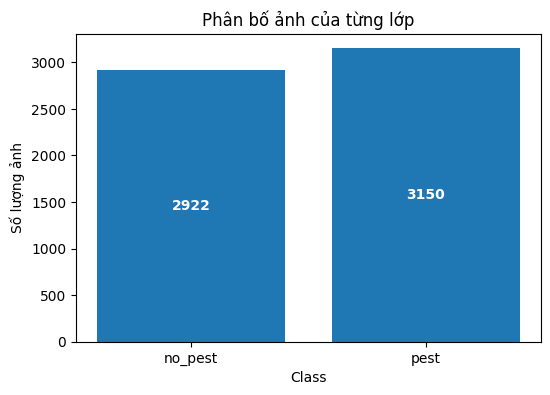

In [ ]:
# Đếm
unique_labels, counts = np.unique(y, return_counts=True)
class_labels = le.inverse_transform(unique_labels)
class_counts = counts
plt.figure(figsize=(6, 4))
bars = plt.bar(class_labels, class_counts)

plt.xlabel('Class')
plt.ylabel('Số lượng ảnh')
plt.title('Phân bố ảnh của từng lớp')

# Ghi số lượng
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height / 2,
        f'{int(height)}',
        ha='center',
        va='center',
        color='white',
        fontweight='bold'
    )

In [ ]:
X = []

for img in X_img_data:
    features = extract_all_features(img)
    X.append(features)

X = np.array(X)

print("Feature matrix shape:", X.shape)

Feature matrix shape: (6072, 19)


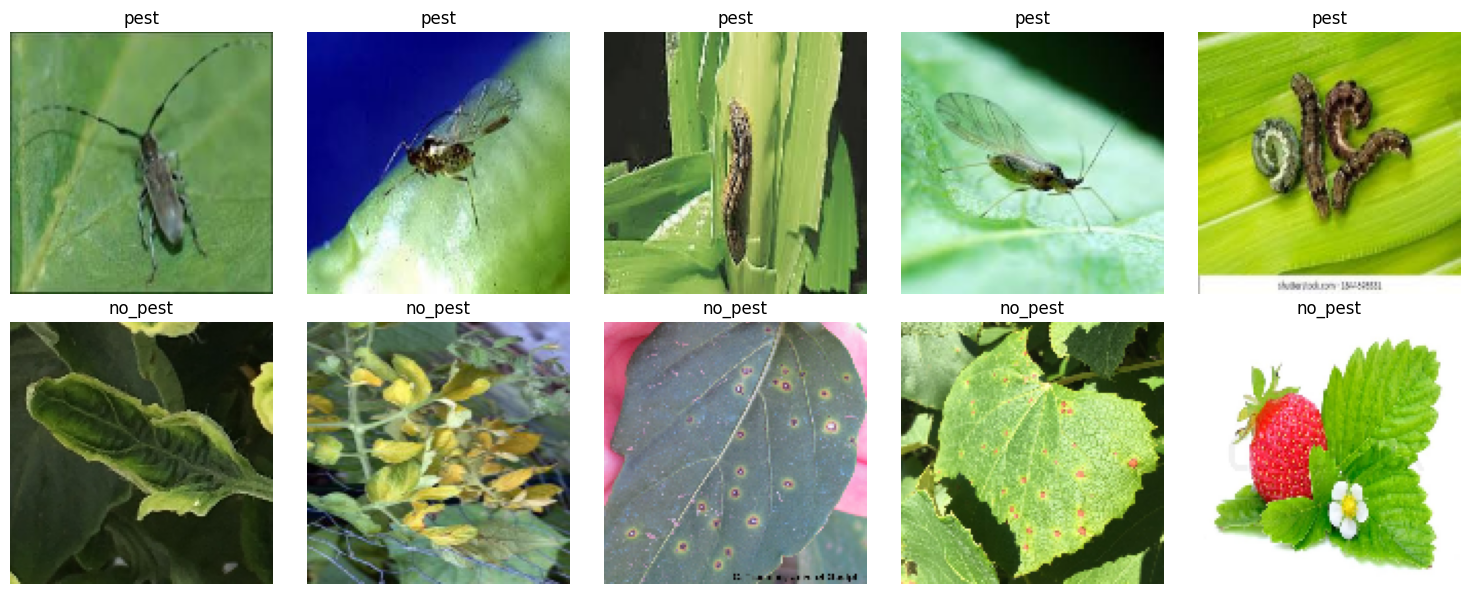

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

pest_indices = np.where(y == le.transform(['pest'])[0])[0]
nopest_indices = np.where(y == le.transform(['no_pest'])[0])[0]

sample_pest = np.random.choice(pest_indices, 5, replace=False)
sample_nopest = np.random.choice(nopest_indices, 5, replace=False)

for i, idx in enumerate(sample_pest):
    axes[0, i].imshow(cv2.cvtColor(X_img_data[idx], cv2.COLOR_BGR2RGB))
    axes[0, i].set_title("pest")
    axes[0, i].axis('off')

for i, idx in enumerate(sample_nopest):
    axes[1, i].imshow(cv2.cvtColor(X_img_data[idx], cv2.COLOR_BGR2RGB))
    axes[1, i].set_title("no_pest")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
feature_names = [f"f{i}" for i in range(X.shape[1])]
df_features = pd.DataFrame(X, columns=feature_names)

display(df_features.describe().T)

,count,mean,std,min,25%,50%,75%,max
f0,6072.0,43.237182,19.287993,0.000000,30.610352,41.513367,52.749390,115.001953
f1,6072.0,105.640344,46.117951,0.000000,74.389389,105.012756,136.330566,250.186218
f2,6072.0,148.936075,39.008877,25.728943,124.243790,144.716034,168.038696,250.716919
f3,6072.0,23.680883,14.992406,0.000000,12.111472,20.724961,31.509683,82.866537
f4,6072.0,50.411468,18.473446,0.000000,37.905834,48.107577,60.401538,124.428913
f5,6072.0,49.799885,14.409060,11.490612,39.771614,48.824732,58.353085,111.281445
f6,6072.0,605.511996,454.972597,50.321438,308.479301,488.616003,768.888490,5003.952448
f7,6072.0,0.234866,0.173757,0.030534,0.110124,0.170525,0.301384,0.905523
f8,6072.0,0.082585,0.153787,0.007695,0.014429,0.022200,0.048160,0.891713
f9,6072.0,0.867540,0.084576,0.316511,0.826729,0.887709,0.926975,0.993238


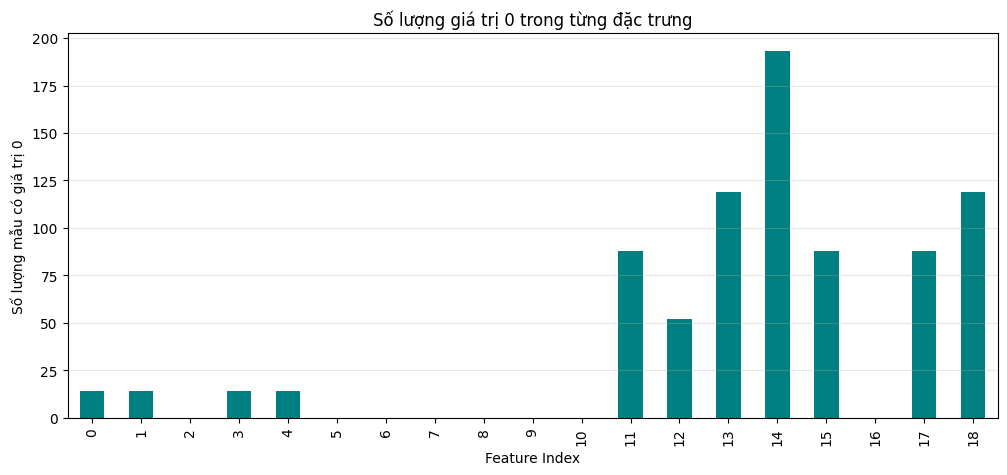

Tổng số mẫu có ít nhất một đặc trưng bằng 0: 274


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Tạo dataframe từ X
df = pd.DataFrame(X)

# Đếm số lượng giá trị 0 trong mỗi đặc trưng
zero_counts = (df == 0).sum()

# Vẽ biểu đồ
plt.figure(figsize=(12, 5))
zero_counts.plot(kind='bar', color='teal')
plt.title('Số lượng giá trị 0 trong từng đặc trưng')
plt.xlabel('Feature Index')
plt.ylabel('Số lượng mẫu có giá trị 0')
plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"Tổng số mẫu có ít nhất một đặc trưng bằng 0: {(df == 0).any(axis=1).sum()}")

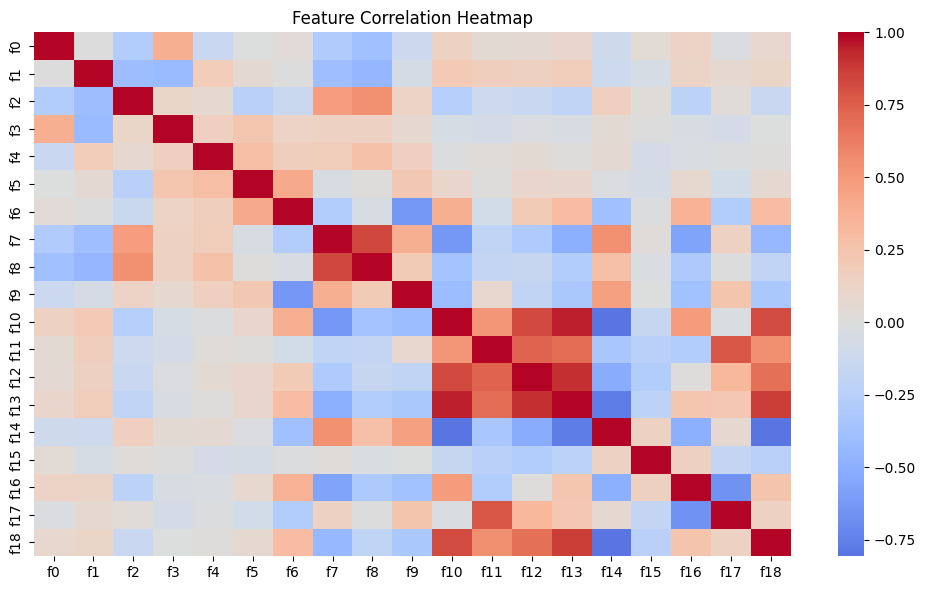

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(df_features.corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

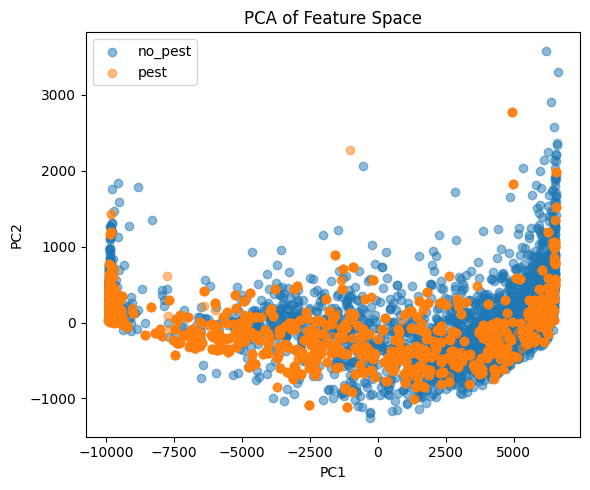

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1], alpha=0.5, label='no_pest')
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1], alpha=0.5, label='pest')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.title("PCA of Feature Space")
plt.tight_layout()
plt.show()

In [ ]:

def validate_dataset(X, y, expected_num_features=19):
    """
    Validate feature matrix X and label vector y
    """
    errors = []

    # 1. Check empty dataset
    if X is None or y is None:
        raise ValueError("X or y is None.")
    if len(X) == 0:
        errors.append("Feature matrix X is empty.")
    if len(y) == 0:
        errors.append("Label vector y is empty.")

    if errors:
        raise ValueError("Data Validation Failed:\n" + "\n".join(errors))

    # 2. Check shape consistency
    if X.shape[0] != y.shape[0]:
        errors.append(
            f"Mismatch between number of samples: X has {X.shape[0]}, y has {y.shape[0]}"
        )

    # 3. Check number of features
    if X.shape[1] != expected_num_features:
        errors.append(
            f"Expected {expected_num_features} features, but got {X.shape[1]}"
        )

    # 4. Check NaN/ Inf values
    if np.isnan(X).any():
        errors.append("Feature matrix contains NaN values.")

    if np.isinf(X).any():
        errors.append("Feature matrix contains Inf values.")

    # 5. Check label validity (binary classification: 0 or 1)
    unique_labels = np.unique(y)
    if not set(unique_labels).issubset({0, 1}):
        errors.append(f"Invalid labels detected: {unique_labels}")

    # 6. Final decision
    if errors:
        raise ValueError(
            "Data Validation Failed:\n" + "\n".join(errors)
        )

    print("Data Validation Passed: Dataset is valid for training.")


# Run validation
validate_dataset(X, y)


Data Validation Passed: Dataset is valid for training.


Number of images in the training set: 4250
Number of images in the validation set: 607
Number of images in the testing set: 1215


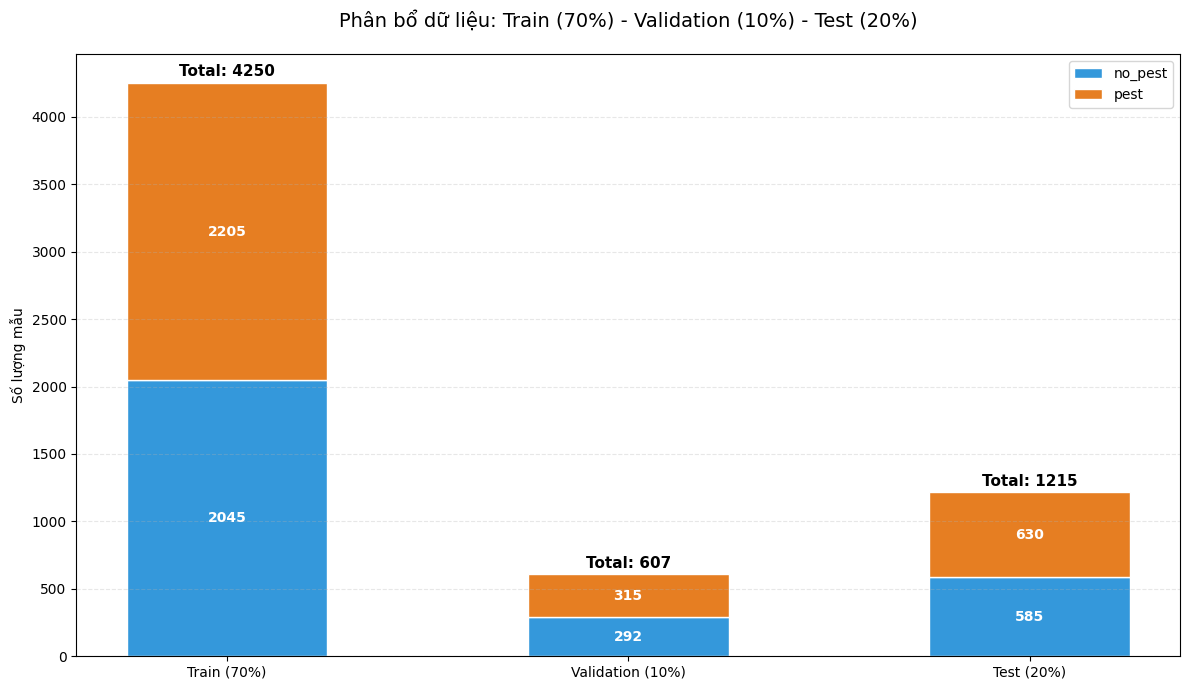

Số lượng mẫu tập Train: 4250
Số lượng mẫu tập Validation: 607
Số lượng mẫu tập Test: 1215


In [ ]:
X_train, X_temp, X_img_train, X_img_temp, y_train, y_temp = train_test_split(X, X_img_data, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, X_img_val, X_img_test, y_val, y_test = train_test_split(X_temp, X_img_temp, y_temp, test_size=2/3, random_state=42, stratify=y_temp)

print(f"Number of images in the training set: {len(X_train)}")
print(f"Number of images in the validation set: {len(X_val)}")
print(f"Number of images in the testing set: {len(X_test)}")

def get_counts(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return counts # Trả về [số lượng no_pest, số lượng pest]

train_c = get_counts(y_train)
val_c = get_counts(y_val)
test_c = get_counts(y_test)

labels = ['Train (70%)', 'Validation (10%)', 'Test (20%)']
no_pest = [train_c[0], val_c[0], test_c[0]]
pest = [train_c[1], val_c[1], test_c[1]]
totals = [len(y_train), len(y_val), len(y_test)]

x = np.arange(len(labels))
width = 0.5

fig, ax = plt.subplots(figsize=(12, 7))

# Vẽ cột chồng
p1 = ax.bar(labels, no_pest, width, label='no_pest', color='#3498db', edgecolor='white')
p2 = ax.bar(labels, pest, width, bottom=no_pest, label='pest', color='#e67e22', edgecolor='white')

# Thêm nhãn số lượng
def add_labels(rects, base_heights=None):
    for i, rect in enumerate(rects):
        height = rect.get_height()
        pos_y = rect.get_y() + height/2
        ax.text(rect.get_x() + rect.get_width()/2., pos_y, f'{int(height)}',
                ha='center', va='center', color='white', fontweight='bold')

add_labels(p1)
add_labels(p2)

# Hiển thị tổng số lượng trên mỗi cột
for i, total in enumerate(totals):
    ax.text(i, total + 50, f'Total: {total}', ha='center', fontweight='bold', fontsize=11)

ax.set_title('Phân bổ dữ liệu: Train (70%) - Validation (10%) - Test (20%)', fontsize=14, pad=20)
ax.set_ylabel('Số lượng mẫu')
ax.legend(loc='upper right')
ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Số lượng mẫu tập Train: {len(y_train)}")
print(f"Số lượng mẫu tập Validation: {len(y_val)}")
print(f"Số lượng mẫu tập Test: {len(y_test)}")

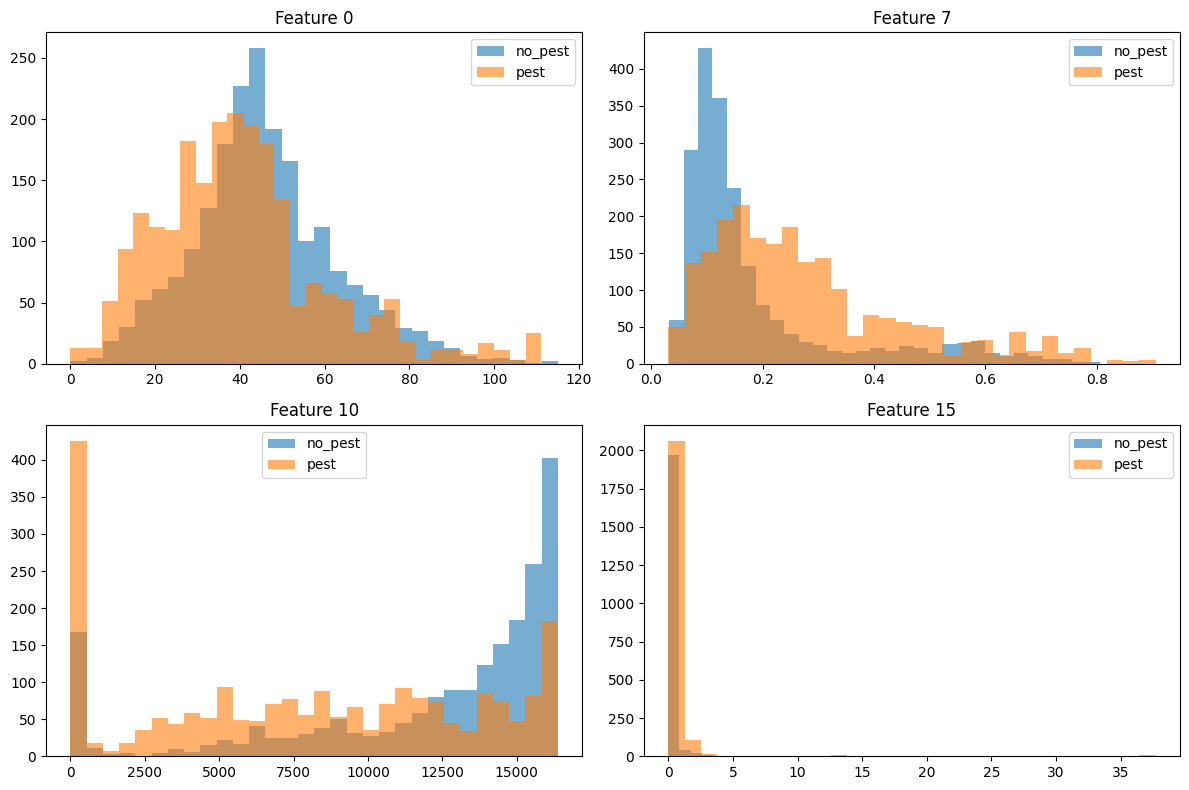

In [ ]:
selected_features = [0, 7, 10, 15]

plt.figure(figsize=(12, 8))
for i, idx in enumerate(selected_features):
    plt.subplot(2, 2, i+1)
    plt.hist(X_train[y_train==0, idx], bins=30, alpha=0.6, label='no_pest')
    plt.hist(X_train[y_train==1, idx], bins=30, alpha=0.6, label='pest')
    plt.title(f"Feature {idx}")
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_test_imp  = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled  = scaler.transform(X_test_imp)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    pipe,
    X_train,
    y_train,
    cv=cv,
    scoring='f1'
)

print("Cross-validation F1 scores:", scores)
print("Mean F1:", scores.mean())


Cross-validation F1 scores: [0.75324675 0.75961538 0.78375149 0.74616293 0.77299185]
Mean F1: 0.7631536820523366


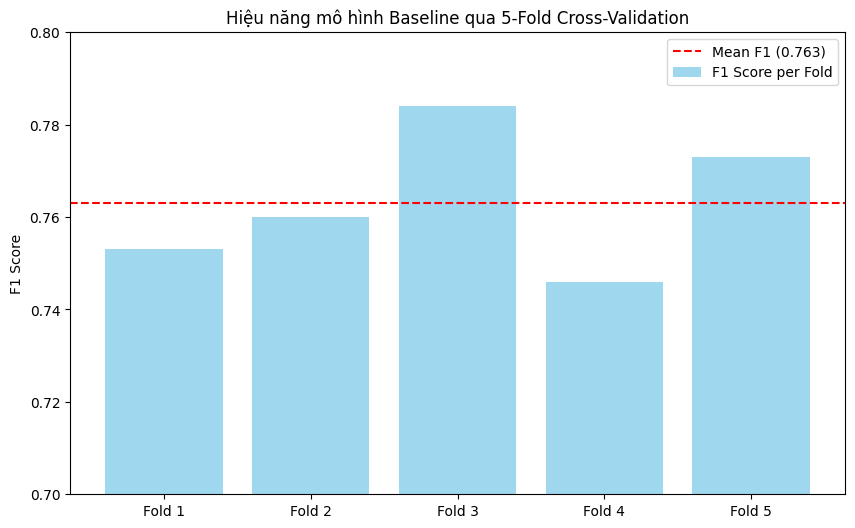

In [ ]:
folds = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
scores = [0.753, 0.760, 0.784, 0.746, 0.773]
mean_f1 = 0.763

plt.figure(figsize=(10, 6))
plt.bar(folds, scores, color='skyblue', alpha=0.8, label='F1 Score per Fold')
plt.axhline(y=mean_f1, color='red', linestyle='--', label=f'Mean F1 ({mean_f1:.3f})')

plt.ylim(0.7, 0.8) # Thu hẹp khoảng nhìn để thấy rõ sự khác biệt
plt.ylabel('F1 Score')
plt.title('Hiệu năng mô hình Baseline qua 5-Fold Cross-Validation')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Train Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Predict
y_pred = logreg.predict(X_test_scaled)

In [ ]:
%%time
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

CPU times: user 2.23 s, sys: 2.7 ms, total: 2.24 s
Wall time: 2.22 s


RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC(kernel='rbf', random_state=42, probability=True)
svm_clf.fit(X_train_scaled, y_train)

SVC(probability=True, random_state=42)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [ ]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=-1,
    class_weight='balanced',
    random_state=42
)

lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)

[LightGBM] [Info] Number of positive: 2205, number of negative: 2045
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4843
[LightGBM] [Info] Number of data points in the train set: 4250, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
from sklearn.pipeline import make_pipeline
svm_pipe = make_pipeline(StandardScaler(), svm_clf)
ensemble = VotingClassifier(
    estimators=[
        ('rf', clf),
        ('svm', svm_pipe),
        ('lgbm', lgbm)
    ],
    voting='soft'
)

ensemble.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 2205, number of negative: 2045
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4843
[LightGBM] [Info] Number of data points in the train set: 4250, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('svm',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('svc',
                                               SVC(probability=True,
                                                   random_state=42))])),
                             ('lgbm',
                              LGBMClassifier(class_weight='balanced',
                                             learning_rate=0.05,
                                             n_estimators=400,
                                             random_state=42))],
                 voting='soft')

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.761317,0.766553,0.761317,0.760936
Random Forest,0.963786,0.965176,0.963786,0.963720
KNN,0.844444,0.850262,0.844444,0.843312
SVM,0.822222,0.822700,0.822222,0.822281
LightGBM,0.965432,0.966666,0.965432,0.965374
Ensemble,0.953909,0.956415,0.953909,0.953778


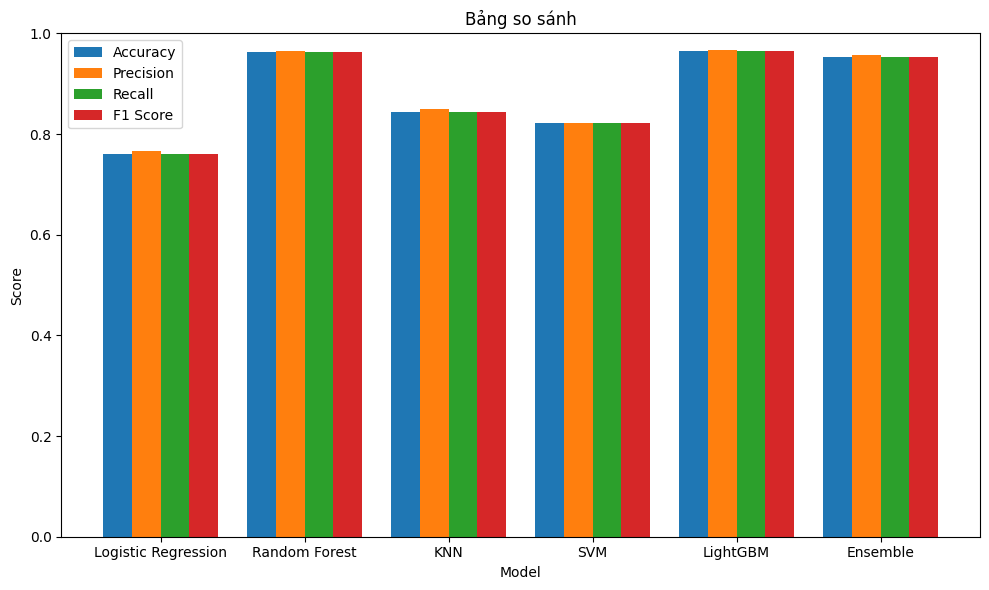

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = {
    'Logistic Regression': logreg,
    'Random Forest': clf,
    'KNN': knn_clf,
    'SVM': svm_clf,
    'LightGBM': lgbm,
    'Ensemble': ensemble
}

# Dự đoán và tính metrics
results = {}

for name, model in models.items():
    if name in ['Logistic Regression', 'SVM', 'KNN']:
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)

    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1 Score': f1_score(y_test, y_pred, average='weighted')
    }

# Chuyển sang DataFrame
df_results = pd.DataFrame(results).T
display(df_results)

# --- Vẽ biểu đồ ---
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(df_results))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

for i, metric in enumerate(metrics):
    ax.bar(x + i*width - width*1.5,
           df_results[metric],
           width,
           label=metric)

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Bảng so sánh')
ax.set_xticks(x)
ax.set_xticklabels(df_results.index)
ax.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


Accuracy: 0.9637860082304527
              precision    recall  f1-score   support

     no_pest       0.99      0.93      0.96       585
        pest       0.94      0.99      0.97       630

    accuracy                           0.96      1215
   macro avg       0.97      0.96      0.96      1215
weighted avg       0.97      0.96      0.96      1215



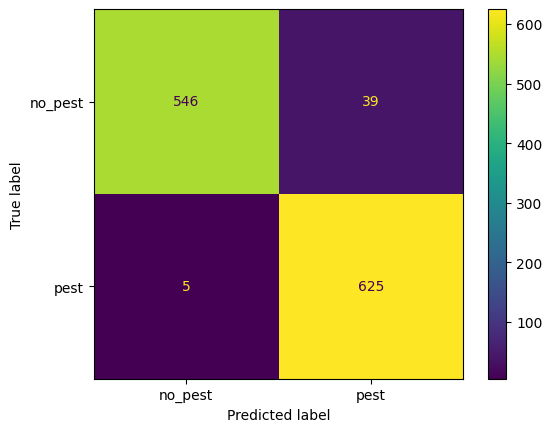

In [ ]:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()
plt.show()

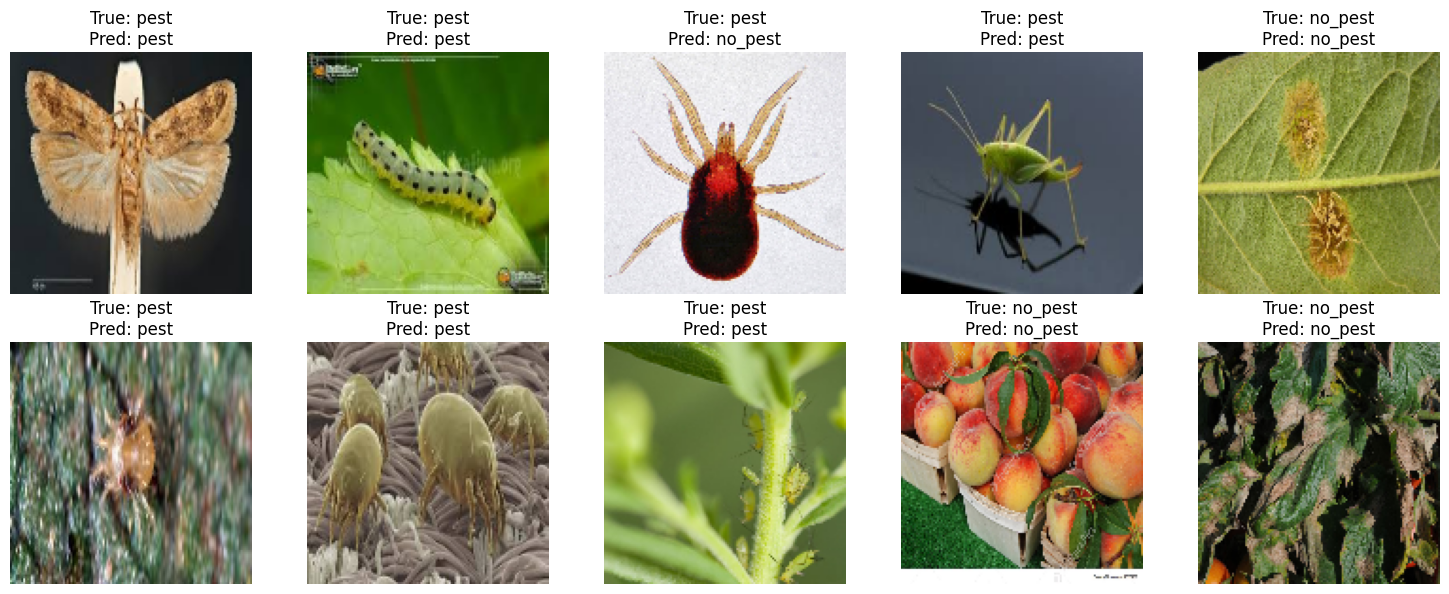

In [ ]:
num_samples = 10
sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
sample_labels = y_test[sample_indices]

# Use X_img_test for actual image data for display
sample_images_for_display = X_img_test[sample_indices]

# Predict using the features (X_test) corresponding to the sampled images
predicted_labels = clf.predict(X_test[sample_indices])

num_cols = 5
num_rows = (num_samples + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
axes = axes.flatten()

for i in range(num_samples):
    ax = axes[i]
    # Display the actual image data
    ax.imshow(cv2.cvtColor(sample_images_for_display[i], cv2.COLOR_BGR2RGB))
    true_label = le.inverse_transform([sample_labels[i]])[0]
    predicted_label = le.inverse_transform([predicted_labels[i]])[0]
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}")
    ax.axis("off")

for j in range(num_samples, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

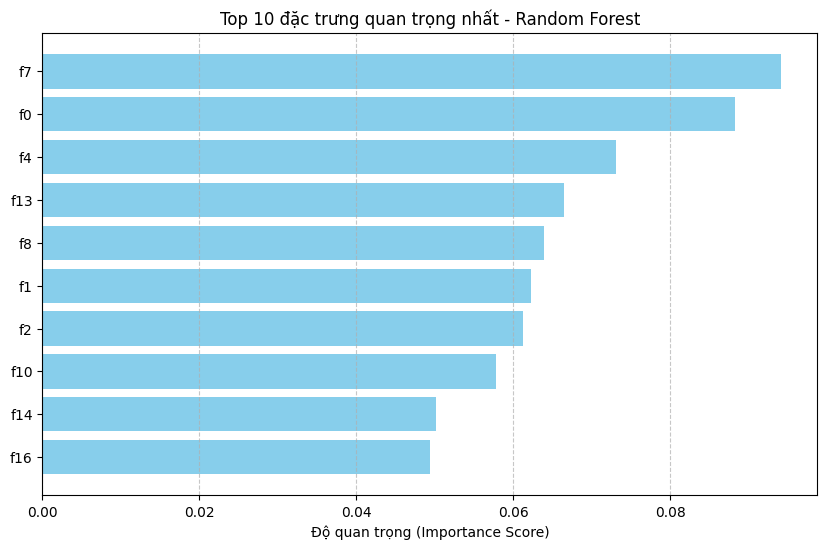

  Feature  Importance
0      f7    0.094085
1      f0    0.088242
2      f4    0.073047
3     f13    0.066509
4      f8    0.063954
5      f1    0.062333
6      f2    0.061275
7     f10    0.057803
8     f14    0.050125
9     f16    0.049373


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Lấy độ quan trọng của đặc trưng
importances = clf.feature_importances_
feature_names = [f'f{i}' for i in range(19)] # Tên đặc trưng từ f0 đến f18

# 2. Sắp xếp theo thứ tự giảm dần
indices = np.argsort(importances)[::-1]

# 3. Tạo DataFrame để dễ quan sát
feature_importance_df = pd.DataFrame({
    'Feature': [feature_names[i] for i in indices],
    'Importance': importances[indices]
})

# 4. Vẽ biểu đồ Top 10 đặc trưng
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10][::-1],
         feature_importance_df['Importance'][:10][::-1],
         color='skyblue')
plt.xlabel('Độ quan trọng (Importance Score)')
plt.title('Top 10 đặc trưng quan trọng nhất - Random Forest')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# In ra giá trị cụ thể
print(feature_importance_df.head(10))

In [ ]:
import joblib
metadata = {
    'model': ensemble,
    'scaler': scaler,
    'imputer': imputer,
    'label_encoder': le
}

joblib.dump(metadata, 'pest_detection_full_pipeline.pkl')
print("Đã lưu toàn bộ Pipeline thành công!")

Đã lưu toàn bộ Pipeline thành công!


In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
import cv2
import numpy as np
import joblib
from PIL import Image
from skimage import morphology, measure
from skimage.feature import graycomatrix, graycoprops

# --- 1. GIỮ NGUYÊN CÁC HÀM TRÍCH XUẤT ĐẶC TRƯNG CỦA BẠN ---
def extract_color_features(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mean = np.mean(hsv, axis=(0, 1))
    std  = np.std(hsv, axis=(0, 1))
    return np.concatenate([mean, std])

def extract_glcm_features(gray):
    glcm = graycomatrix(gray, distances=[1],
                        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        symmetric=True, normed=True)
    contrast    = graycoprops(glcm, 'contrast').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    energy      = graycoprops(glcm, 'energy').mean()
    correlation = graycoprops(glcm, 'correlation').mean()
    return np.array([contrast, homogeneity, energy, correlation])

def extract_shape_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    edges = cv2.magnitude(sobelx, sobely)
    edges = np.uint8(edges)
    _, binary = cv2.threshold(edges, 50, 255, cv2.THRESH_BINARY)
    binary = morphology.binary_closing(binary/255, morphology.disk(3))
    binary = binary.astype(np.uint8)
    labeled = measure.label(binary)
    props = measure.regionprops(labeled)
    if len(props)==0: return np.zeros(9)
    p = props[0]
    area, perimeter = p.area, p.perimeter
    major, minor = p.major_axis_length, p.minor_axis_length
    circularity = 4*np.pi*area/(perimeter**2) if perimeter>0 else 0
    form_factor = (perimeter**2)/(4*np.pi*area) if area>0 else 0
    compactness = (minor/major) if major>0 else 0
    return np.array([area, perimeter, major, minor, p.eccentricity,
                     circularity, p.solidity, form_factor, compactness])

def extract_all_features(img):
    img_resized = cv2.resize(img, (128, 128))
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    f_color   = extract_color_features(img_resized)
    f_texture = extract_glcm_features(gray)
    f_shape   = extract_shape_features(img_resized)
    return np.concatenate([f_color, f_texture, f_shape]).reshape(1, -1)

# --- 2. HÀM XỬ LÝ CHÍNH CHO GRADIO ---
def predict_pest(input_img):
    # Tải model
    data = joblib.load('pest_detection_full_pipeline.pkl')
    model = data['model']
    le = data['label_encoder']

    # Chuyển ảnh từ RGB (Gradio) sang BGR (OpenCV)
    img_opencv = cv2.cvtColor(input_img, cv2.COLOR_RGB2BGR)

    # Trích xuất và Dự đoán
    features = extract_all_features(img_opencv)
    pred = model.predict(features)
    prob = model.predict_proba(features)[0]

    # Kết quả
    label = le.inverse_transform(pred)[0]
    results = {le.classes_[i]: float(prob[i]) for i in range(len(le.classes_))}

    return label.upper(), results

# --- 3. KHỞI TẠO GIAO DIỆN GRADIO ---
interface = gr.Interface(
    fn=predict_pest,
    inputs=gr.Image(),
    outputs=[gr.Textbox(label="Kết quả dự đoán"), gr.Label(label="Xác suất chi tiết")],
    title="🌱 MACHINE LEARNING PHÁT HIỆN CÔN TRÙNG GÂY HẠI CHO CÂY TRỒNG QUA HÌNH ẢNH",
    description="Tải ảnh lá cây lên để AI phân tích"
)

# Chạy app với link share công khai
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://eee07396cc18d94061.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
